In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# read the rotated.txt 
coordinates = []
with open('rotated.txt','r') as coord_file:
    while True:
        p = coord_file.readline().strip('\n')
        if p == '':
            break
        x,y = p.split('\t')
        coordinates.append((float(x),float(y)))

In [3]:
left_pupil = coordinates.pop() # last coord
right_pupil = coordinates.pop() # before last coord 

left_pupil , right_pupil

((878.1667, 480.0), (378.8333, 480.0))

In [4]:
len(coordinates)

18

In [5]:
upper_right_contour = coordinates[:len(coordinates)//2]
upper_left_contour = coordinates[len(coordinates)//2:]

len(upper_left_contour) , len(upper_right_contour)


(9, 9)

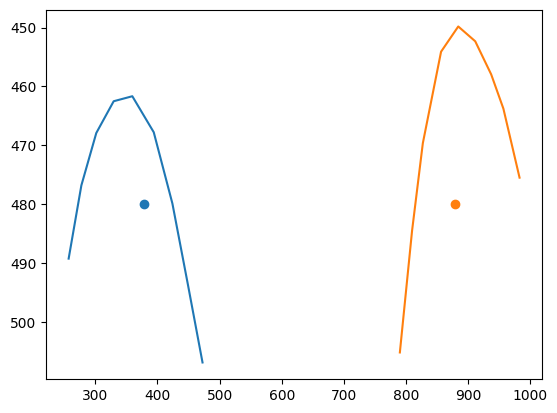

In [14]:
if not plt.gca().yaxis_inverted():
    plt.gca().invert_yaxis()


plt.scatter(right_pupil[0],right_pupil[1])
plt.scatter(left_pupil[0],left_pupil[1])

x_right = [p[0] for p in upper_right_contour]
y_right = [p[1] for p in upper_right_contour]
curve = np.polyfit(x_right,y_right,5)
fx = np.poly1d(curve)
plt.plot(x_right,fx(x_right))

x_left = [p[0] for p in upper_left_contour]
y_left = [p[1] for p in upper_left_contour]
curve = np.polyfit(x_left,y_left,5)
gx = np.poly1d(curve)
plt.plot(x_left,gx(x_left))

plt.show()


In [7]:
abs(round(fx(right_pupil[0]) - right_pupil[1],0) / 10) 

1.6

In [8]:
abs(round(gx(left_pupil[0]) - left_pupil[1],0) / 10) 

3.0

In [9]:
abs(x_right[np.argmax(fx(x_right))] - right_pupil[0]) #mrd1-phul 

93.66669999999999

In [10]:
abs(x_left[np.argmax(gx(x_left))] - left_pupil[0]) #mrd1-phul 

88.0